# Modellierung Windeinspeisung

**Lernziele**
- Modellaufbau mit funktionaler API
- Aufbau Multi-Output KNN
- Umsetzung einer eigenen Verlustfunktion "Pinball-loss"
- Umsetzung Quantilsregression

## Pakete und Daten laden

In [2]:
# Laden von notwendigen Paketen
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from statsmodels import api as sm
import statsmodels.formula.api as smf

from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow import keras
import tensorflow as tf
import tensorboard
tensorboard.__version__

#standardeinstellungen
plt.rcParams['axes.xmargin'] = 0
pd.set_option('display.precision',2)
np.set_printoptions(precision=3)
%load_ext tensorboard

#Eigene Module und Klassen
import sys
# temporäre Einbinden des neuen Pfades mit zu ladenden Dateien
sys.path.append("C:\\Users\\rs3753e\\sciebo\\Vorlesungen\\SoSe_Energiedatenanalyse Datamining\\internalfunctions\\")
from KNN import KNN

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
# Laden des vorbereiteten WinddatenFrame
wind=pd.read_hdf('../daten/windeinspeisung_bereinigt','Obj1')
wind

,Pitch,Rspeed,Gspeed,S_avg,S_min,S_max,S_std,P_avg,P_min,P_max,...,Q_avg,Ws_avg,Ws_min,Ws_max,Ws_std,Wdir,Nadir,Va_avg,Va_std,Temp
Date_time,,,,,,,,,,,,,,,,,,,,,
2012-12-31 23:00:00+00:00,-1.00,17.18,1800.99,1072.79,757.84,1399.74,116.39,1072.65,757.32,1399.74,...,14.49,8.96,6.48,11.26,0.81,180.25,176.44,3.78,7.31,5.09
2012-12-31 23:10:00+00:00,-1.00,17.17,1799.97,1061.75,661.90,1398.57,142.63,1061.43,660.95,1398.45,...,23.70,8.89,5.78,11.65,1.01,183.29,176.44,6.90,7.56,5.26
2012-12-31 23:20:00+00:00,-1.00,17.18,1801.19,1145.14,797.27,1529.85,162.52,1144.79,795.96,1529.84,...,25.48,9.19,6.10,11.33,1.01,185.08,176.44,8.63,7.49,5.56
2012-12-31 23:30:00+00:00,-1.00,17.18,1801.14,1184.32,764.87,1701.61,194.35,1183.98,763.56,1701.45,...,24.38,8.92,6.05,12.15,1.13,190.33,188.41,-2.60,12.38,5.70
2012-12-31 23:40:00+00:00,-0.98,17.18,1801.01,1317.69,819.66,1854.88,215.61,1317.55,818.96,1854.86,...,14.47,9.48,6.14,12.48,1.10,188.07,192.90,-4.78,9.61,5.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 22:10:00+00:00,45.00,1.39,148.74,0.56,0.26,1.08,0.13,-0.56,-1.08,-0.26,...,0.00,3.30,2.68,3.65,0.17,195.14,195.14,-14.51,3.91,3.83
2016-12-31 22:20:00+00:00,45.00,1.54,165.22,0.73,0.25,1.42,0.23,-0.73,-1.42,-0.25,...,0.00,3.46,2.97,3.84,0.16,196.18,196.18,-13.46,4.01,3.66
2016-12-31 22:30:00+00:00,19.59,5.65,597.10,23.17,0.27,162.95,27.83,20.95,-18.21,162.58,...,4.69,3.87,2.92,5.23,0.37,195.72,195.72,-13.91,9.34,3.52


## Datenorganisation

Erstellung eines KNN-Objektes mit normierten/Standardisierten Trainings/Validierungs- und Testdaten

In [6]:
# Vorgaben zur Datentrennung
sections=(.6,.25,.15)
shuffle=False

# Vorbereitete Klasse
model = KNN()
# Unterteilung der Samples
model.split_sample(pd.DataFrame(wind["Ws_avg"]),pd.DataFrame(wind["S_avg"]),shuffle=shuffle,sections =sections)
#Auswahl der Skalierungsmethode
model.scaler("MinMax")

## Erstellung eines KNN zur Prognose der Einspeisung

**Definition Features und Output**

In [7]:
_,model.numFeatures = model.x[0].shape

# Auzahl der Ausgaben wird durch die Anzahl der zu berechnenden Quantile bestimmt
model.quantile =[0.05,0.5,0.95]
model.qaunt_names=["Q05","Q50","Q95"]
model.numResponses = len(model.quantile);

### Modellaufbau mit Keras-Sequential Schreibweise

In [8]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Input
import functools

def build_model():
    
    # Define model layers.
    input_layer = Input(shape=(model.numFeatures,))
    
    # Hidden Layer
    dense1 = Dense(units='150', activation='relu',name='dense1')(input_layer)
    dense2 = Dense(units='150',activation='relu',name='dense2')(dense1)
    dense3 = Dense(units='150',activation='relu',name='dense3')(dense2)
    
    # Für jedes Quanti´l wird ein Output-Layer angelegt
    y_output=list()
    for i in range(model.numResponses):
        y_output.append(Dense(units='1', name=model.qaunt_names[i])(dense3))    
    
    # Verbindung von Input und Output-Schicht   
    KNN = Model(inputs=input_layer,outputs=y_output)
    
    # Rückgabe
    return KNN

model.KNN = build_model()

# Zusammenfassung 1 (tabellarisch)
model.KNN.summary()
# Zusammenfassung 2 (graphisch)
keras.utils.plot_model(model.KNN, "my_first_model_with_shape_info.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 150)          300         input_1[0][0]                    
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 150)          22650       dense1[0][0]                     
__________________________________________________________________________________________________
dense3 (Dense)                  (None, 150)          22650       dense2[0][0]                     
______________________________________________________________________________________________

### Definition der neuen Verlustfunktion (pinball_loss)

In [9]:
def pinball_loss(y_true, y_pred, tau):
    
    err = y_true-y_pred                     # error
       
    eps =0.001                                
    
    h=tf.where(tf.math.abs(err)>eps,        # condition
               tf.math.abs(err)-(eps/2),    # execution if true 
               tf.math.pow(err,2)/(2*eps))  # execution if false 
      
    L = tf.where(y_pred>=y_true,            # condition        
                 (1-tau)*h,                 # execution if true
                 tau*h)                     # execution if false
    
    return tf.math.reduce_mean(L, axis=-1)  # loss-function

    # Alternativ pinball loss mit Unstetigkeit
    # return tf.math.reduce_mean( \
    #        tf.math.maximum(tau * err, (tau - 1) * err), axis=-1)

In [10]:
# Test der Funktion
y_true=np.array([5.,5.,4.])
y_pred=np.array([4.,6.,4.])
pinball_loss(y_true, y_pred, .2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.33316666666666667>

**Anpassung der Compile Methode**

mit Übertragung von n partiellen Verlustfunktionen (zur Parametrierung von  n Qunatilen

In [11]:
lossfun=dict()
for i in range(3):
    lossfun[model.qaunt_names[i]] = functools.partial(pinball_loss, tau=model.quantile[i])
model.KNN.compile(optimizer='adam',loss=lossfun)
model.early = EarlyStopping(monitor='val_loss', patience=100)

**Trainieren des neuronalen Netzes**

In [12]:
history = model.KNN.fit(model.x_norm[0],model.y_norm[0],epochs=20, \
                        batch_size=1000,validation_data=(model.x_norm[1],model.y_norm[1]),callbacks=[model.early])

Epoch 1/20
122/122 [==============================] - 3s 10ms/step - loss: 0.0485 - Q05_loss: 0.0068 - Q50_loss: 0.0255 - Q95_loss: 0.0163 - val_loss: 0.0246 - val_Q05_loss: 0.0089 - val_Q50_loss: 0.0129 - val_Q95_loss: 0.0028
Epoch 2/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0173 - Q05_loss: 0.0050 - Q50_loss: 0.0097 - Q95_loss: 0.0026 - val_loss: 0.0234 - val_Q05_loss: 0.0084 - val_Q50_loss: 0.0122 - val_Q95_loss: 0.0028
Epoch 3/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0171 - Q05_loss: 0.0050 - Q50_loss: 0.0095 - Q95_loss: 0.0026 - val_loss: 0.0236 - val_Q05_loss: 0.0084 - val_Q50_loss: 0.0124 - val_Q95_loss: 0.0028
Epoch 4/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0171 - Q05_loss: 0.0050 - Q50_loss: 0.0096 - Q95_loss: 0.0025 - val_loss: 0.0244 - val_Q05_loss: 0.0084 - val_Q50_loss: 0.0132 - val_Q95_loss: 0.0028
Epoch 5/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0171 - Q05_loss: 0.

**Plot Verlauf der Verlustfunktion**

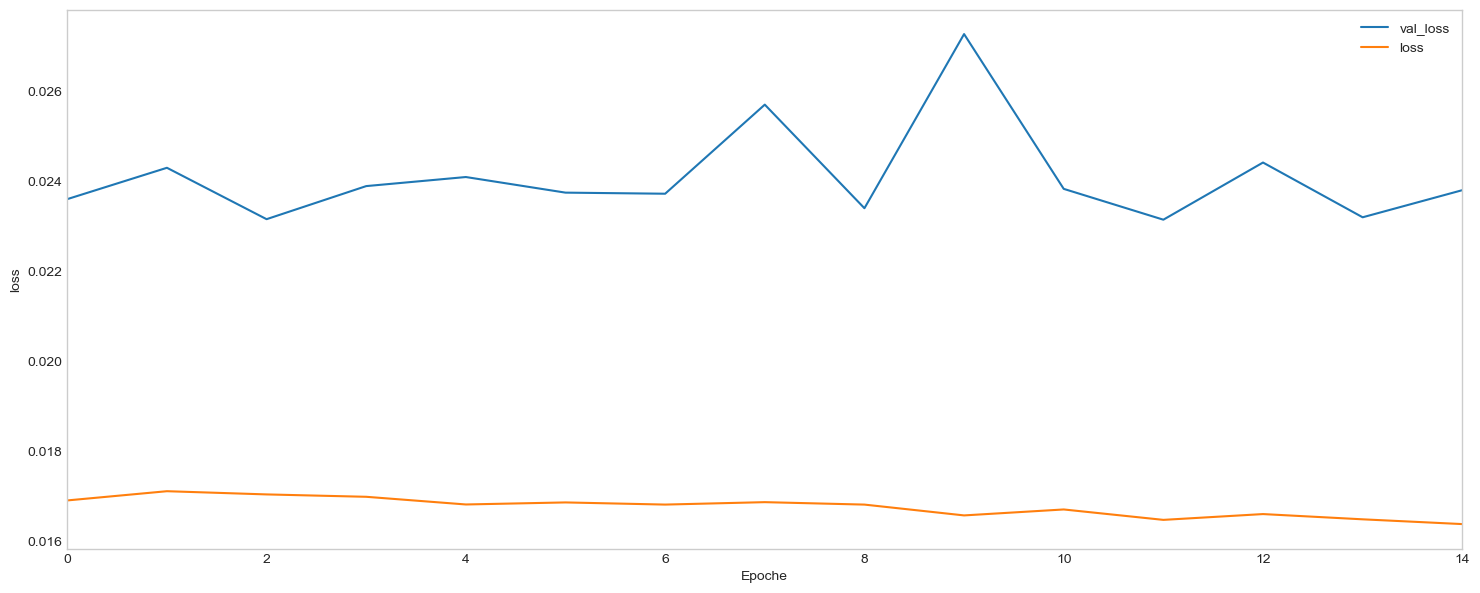

In [13]:
fig, ax =plt.subplots(nrows=1,ncols=1,**{'figsize': (18, 7)})
# ersten 5 werden ausgeblendet
lin1 = ax.plot(history.history['val_loss'][5:],label='val_loss')
lin2 = ax.plot(history.history['loss'][5:],label='loss')
ax.set(xlabel='Epoche',ylabel='loss')
ax.legend();ax.grid()

**Prognose von Training, Validierungs- und Testdaten**

In [14]:
# Prognose
ypred_norm =list();[ypred_norm.append(np.squeeze(model.KNN.predict(model.x_norm[i])).T) for i in range(3)];
# Inverse Scalierung
ypred =list();[ypred.append(model.scalerY.inverse_transform(ypred_norm[i])) for i in range(3)];

**Verlauf Plot Orginal vs. Prognose**

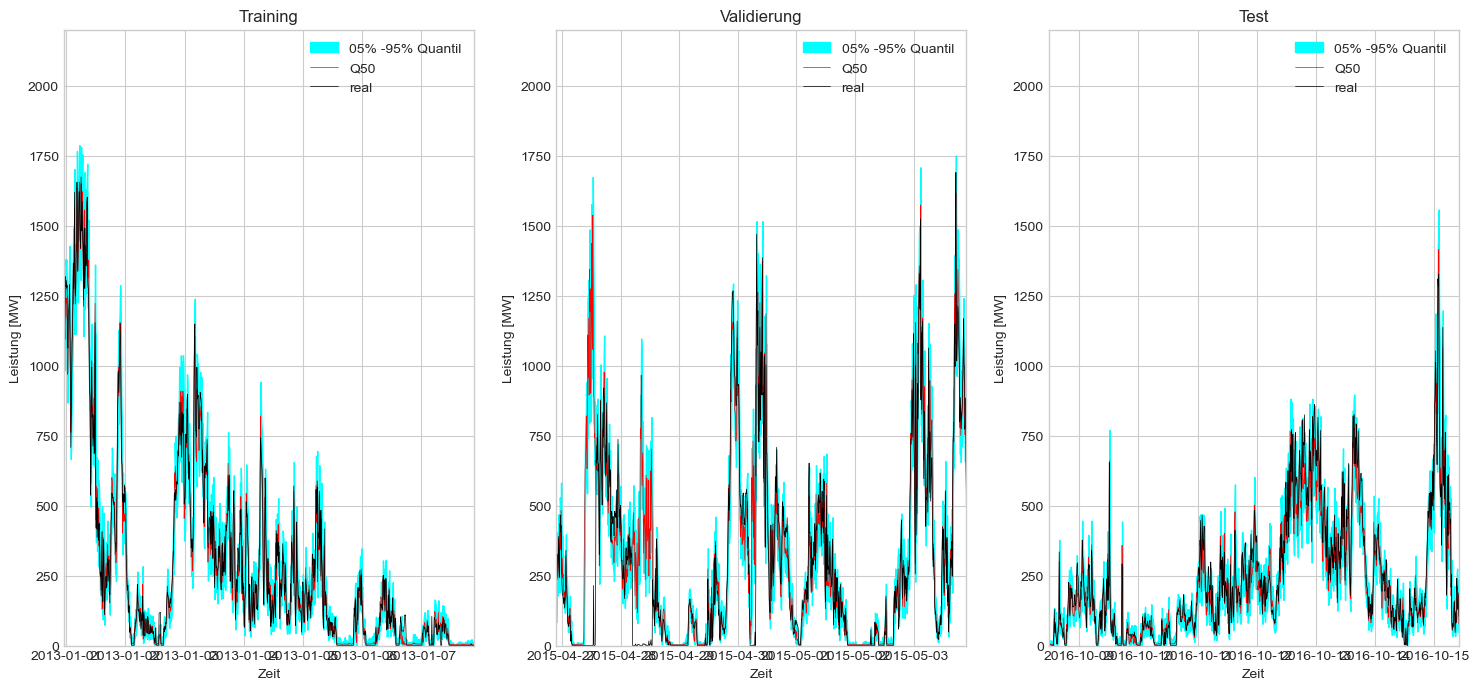

In [15]:
lab =["Training", "Validierung","Test"]
fig, ax =plt.subplots(nrows=1,ncols=3,**{'figsize': (18, 8)})
for i in range(3):
    # Bereich der Quantile
    ax[i].fill_between(model.x[i].index[0:1000], ypred[i][0:1000,0], ypred[i][0:1000,-1],color = 'cyan',label = '05% -95% Quantil')

    # 50% Quantil
    zeig = np.nonzero(np.array(model.quantile) == 0.5)[0]
    ax[i].plot(model.x[i].index[0:1000],ypred[i][0:1000,zeig[0]],label=model.qaunt_names[zeig[0]],color = 'r',linewidth =.5)

    # realer Wert
    ax[i].plot(model.x[i].index[0:1000],model.y[i][0:1000],label='real',color = 'k',linewidth =.5)
    ax[i].set(ylabel="Leistung [MW]",xlabel="Zeit",title=lab[i],ylim=(0,2200));
    ax[i].legend();

**Scatter**

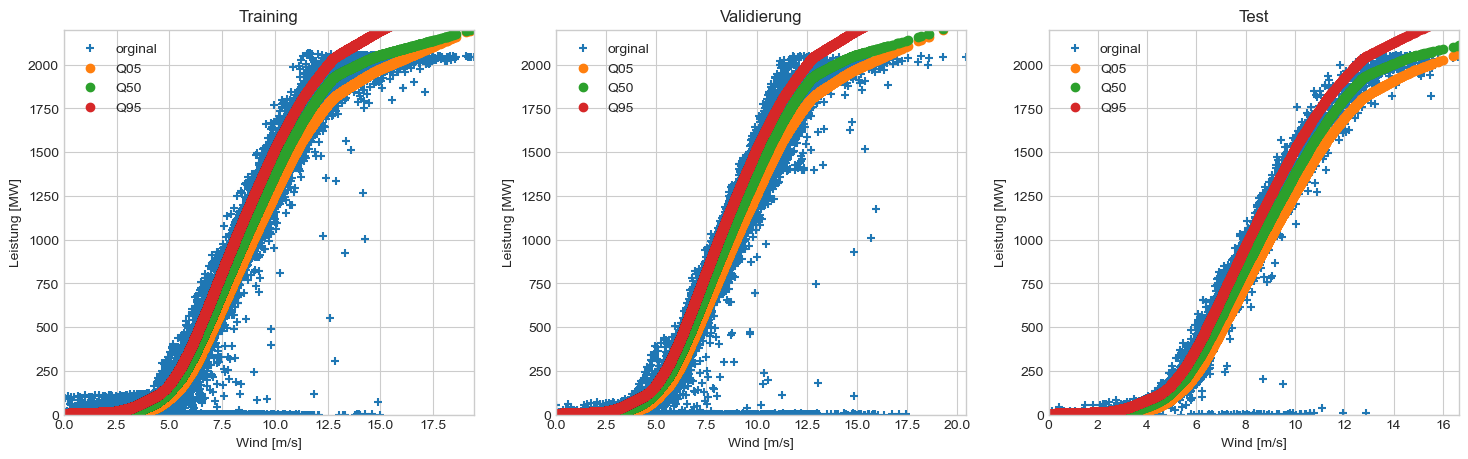

In [16]:
fig, ax =plt.subplots(nrows=1,ncols=3,**{'figsize': (18, 5)})
for i in range(3):
    lin1=ax[i].scatter(model.x[i].iloc[:,0],model.y[i][:],label='orginal',linestyle ="None",marker='+');
    for j in range(len(model.quantile)):
        lin1=ax[i].scatter(model.x[i].iloc[:,0],ypred[i][:,j],label=model.qaunt_names[j],linestyle ="None",marker='o');
    ax[i].set(ylabel="Leistung [MW]",xlabel="Wind [m/s]",title=lab[i],ylim=(0,2200));
    ax[i].legend();